<a href="https://colab.research.google.com/github/yedhuk/basic-machine-learning-algorithms-from-scratch/blob/main/Word2Vec_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Based on the following articles

https://jaketae.github.io/study/word2vec/


http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/


http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [24]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''


In [25]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())


In [26]:
tokens = tokenize(text)

In [27]:
tokens[:5]

['machine', 'learning', 'is', 'the', 'study']

In [28]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word


In [29]:
word_to_id, id_to_word = mapping(tokens)



In [30]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable


In [31]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res


In [32]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)


In [33]:
X, y = generate_training_data(tokens, word_to_id, 2)


In [34]:
X.shape

(330, 60)

In [35]:
y.shape

(330, 60)

In [36]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [37]:
model = init_network(len(word_to_id), 10)

In [38]:
def forward(model, X, return_cache=True):
    cache = {}

    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])

    if not return_cache:
        return cache["z"]
    return cache

In [39]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [40]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [41]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [42]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

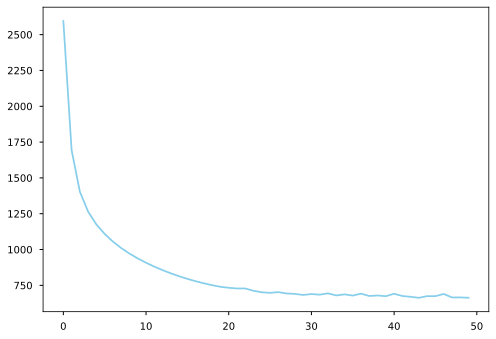

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn-v0_8-notebook")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()


In [44]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
so
the
intelligence
is
build
are
algorithms
of
perform
that
conventional
tasks
do
email
order
such
subset
variety
programmed
predictions
as
infeasible
needed
in
study
used
a
through
and
model
computer
learning
artificial
applications
vision
to
without
training
experience
sample
where
develop
improve
make
wide
based
filtering
it
explicitly
data
decisions
automatically
known
seen
mathematical
or
difficult
being
on


In [45]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]